In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchvision import models
from torchsummary import summary
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import pandas as pd

In [0]:
'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


In [0]:
'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
num_epochs = 10
n_iters = num_epochs*(len(train_dataset)/ batch_size)
n_iters = int(n_iters)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        # Dropout module with 0.3 drop probability
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc3(x), dim=1)

        return x
        
model=Network()
optimizer=optim.SGD(model.parameters(),lr=1e-2,weight_decay=1e-6, momentum=0.9, nesterov=True)
#optimizer=optim.SGD(model.parameters(),lr=1e-2)
criterion=nn.NLLLoss()

In [19]:
## Train

epochs=num_epochs
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/10..  Training Loss: 0.752..  Test Loss: 0.270..  Test Accuracy: 0.922
Epoch: 2/10..  Training Loss: 0.284..  Test Loss: 0.178..  Test Accuracy: 0.946
Epoch: 3/10..  Training Loss: 0.207..  Test Loss: 0.141..  Test Accuracy: 0.957
Epoch: 4/10..  Training Loss: 0.167..  Test Loss: 0.114..  Test Accuracy: 0.966
Epoch: 5/10..  Training Loss: 0.142..  Test Loss: 0.101..  Test Accuracy: 0.968
Epoch: 6/10..  Training Loss: 0.124..  Test Loss: 0.089..  Test Accuracy: 0.973
Epoch: 7/10..  Training Loss: 0.112..  Test Loss: 0.084..  Test Accuracy: 0.974
Epoch: 8/10..  Training Loss: 0.102..  Test Loss: 0.079..  Test Accuracy: 0.976
Epoch: 9/10..  Training Loss: 0.092..  Test Loss: 0.078..  Test Accuracy: 0.976
Epoch: 10/10..  Training Loss: 0.084..  Test Loss: 0.071..  Test Accuracy: 0.979


In [20]:
print("Our model: \n\n", model, '\n')

Our model: 

 Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
) 



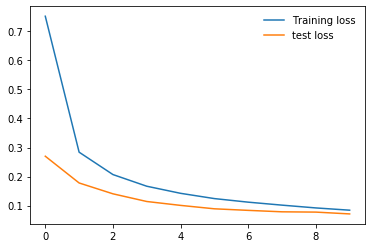

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='test loss')
plt.legend(frameon=False)

In [22]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

235146

In [23]:
#pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_trainable_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_trainable_params

235146